In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt


In [ ]:
# Function to load and resize images
def load_image(path, max_size=512, shape=None):
    image = Image.open(path).convert('RGB')

    # Resize for faster processing
    size = min(max(image.size), max_size)
    if shape is not None:
        size = shape

    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    image = transform(image)[:3, :, :].unsqueeze(0)
    return image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Replace with your paths
content_path = "/content/drive/MyDrive/IE643/CourseProject/clean.jpg"  # Clean dataset image
style_path = "/content/drive/MyDrive/IE643/CourseProject/style.png"  # One extreme shifted image

content = load_image(content_path).to(device)
style = load_image(style_path, shape=content.shape[-2:]).to(device)


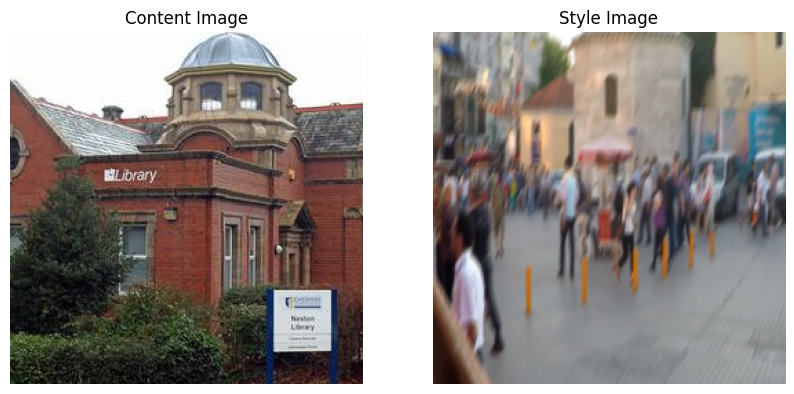

In [ ]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = image * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    image = image + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    image = torch.clamp(image, 0, 1)
    plt.imshow(image.permute(1, 2, 0))
    if title:
        plt.title(title)
    plt.axis("off")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
imshow(content, title='Content Image')
plt.subplot(1,2,2)
imshow(style, title='Style Image')
plt.show()


In [ ]:
# Use pretrained VGG19 for feature extraction
vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features.to(device).eval()

# Layers chosen for content and style
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# Extract features from intermediate layers
def get_features(image, model):
    features = {}
    x = image
    layer_names = ['conv_1','relu_1','conv_2','relu_2','conv_3','relu_3',
                   'conv_4','relu_4','conv_5','relu_5']
    i = 0
    for layer in model.children():
        x = layer(x)
        if isinstance(layer, nn.Conv2d):
            name = layer_names[i]
            features[name] = x
            i += 1
        if i >= len(layer_names):
            break
    return features

# Gram matrix for style representation
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram


In [ ]:
# Extract features
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# Compute Gram matrices for style layers
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_layers}

# Define weights for layers
style_weights = {'conv_1': 1.0, 'conv_2': 0.8, 'conv_3': 0.5, 'conv_4': 0.3, 'conv_5': 0.1}
content_weight = 1e6   # alpha
style_weight = 1e2     # beta


In [ ]:
# Start from the content image (can also start from noise)
target = content.clone().requires_grad_(True).to(device)

optimizer = optim.Adam([target], lr=0.003)


In [ ]:
# Precompute and detach features (no gradients needed)
with torch.no_grad():
    content_features = get_features(content, vgg)
    style_features = get_features(style, vgg)
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_layers}


In [ ]:
steps = 1000  # you can lower this to 300–500 for faster runs

for step in range(1, steps + 1):
    optimizer.zero_grad()

    # Extract target features
    target_features = get_features(target, vgg)

    # Content loss
    content_loss = torch.mean((target_features['conv_4'] - content_features['conv_4'])**2)

    # Style loss
    style_loss = 0
    for layer in style_layers:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_loss / (target_feature.shape[1]**2)

    total_loss = content_weight * content_loss + style_weight * style_loss

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    # Clamp pixel values to valid range
    with torch.no_grad():
        target.clamp_(0, 1)

    if step % 5 == 0:
        print(f"Step [{step}/{steps}]  Total Loss: {total_loss.item():.2f}")


Step [5/1000]  Total Loss: 10772747.00
Step [10/1000]  Total Loss: 9651518.00
Step [15/1000]  Total Loss: 8688401.00
Step [20/1000]  Total Loss: 7937665.50
Step [25/1000]  Total Loss: 7332875.00
Step [30/1000]  Total Loss: 6835642.00
Step [35/1000]  Total Loss: 6413601.50
Step [40/1000]  Total Loss: 6049529.00
Step [45/1000]  Total Loss: 5735190.50
Step [50/1000]  Total Loss: 5463553.00
Step [55/1000]  Total Loss: 5226072.00
Step [60/1000]  Total Loss: 5016847.00
Step [65/1000]  Total Loss: 4831616.00
Step [70/1000]  Total Loss: 4665650.00
Step [75/1000]  Total Loss: 4515013.00
Step [80/1000]  Total Loss: 4378630.00
Step [85/1000]  Total Loss: 4253989.00
Step [90/1000]  Total Loss: 4139669.00
Step [95/1000]  Total Loss: 4034333.00
Step [100/1000]  Total Loss: 3937246.00
Step [105/1000]  Total Loss: 3847555.50
Step [110/1000]  Total Loss: 3764233.00
Step [115/1000]  Total Loss: 3686454.75
Step [120/1000]  Total Loss: 3613976.50
Step [125/1000]  Total Loss: 3545891.25
Step [130/1000]  To

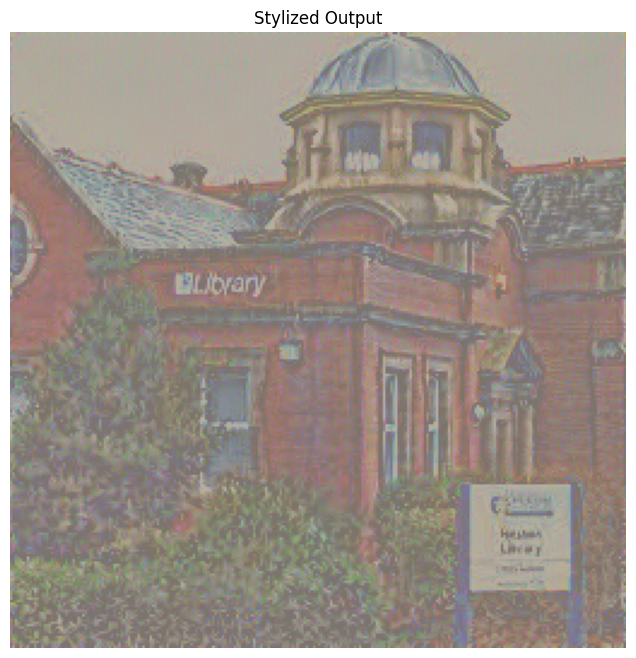

Stylized image saved at: /content/drive/MyDrive/IE643/CourseProject/stylized_NST.png


In [ ]:
plt.figure(figsize=(8,8))
imshow(target.detach(), title="Stylized Output") # Added .detach()
plt.show()

# (Optional) save result
out_path = "/content/drive/MyDrive/IE643/CourseProject/stylized_NST.png"

# 🟢 Detach from graph before converting
unloader = transforms.ToPILImage()
image = target.cpu().detach().clone().squeeze(0)  # <-- detach added
image = image * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
image = image + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
image = torch.clamp(image, 0, 1)
image = unloader(image)
image.save(out_path)

print(f"Stylized image saved at: {out_path}")